# gan_image_generation
As part of the data serialization process, we analyze and store metadata on each frame of the film in the dataframes `vision_df` and `face_df`. We've previously used this metadata to copy and shuffle frames that meet a certain criteria, into a new folder. We can use a folder of movie frames featuring a single primary character's face to try and train a GAN.

A GAN, or generative adverserial network, is a pair of two models that work together to create new images that look like the training images. The discriminator resembles an image classification model, while the generator creates images out of random noise. By discriminator trains on the movie frames, learning what they look like, and the generator attempts to create synthetic images to fool the discriminator into thinking they're real. As both models improve, we'll eventually be able to create images that look like the real thing; in this case, movie frames with a single primary character.

This notebook is being run in a Docker notebook using a Tensorflow/Jupyter image, for ease of GPU training.

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

Because we're using a pre-built Docker image, we don't have the luxury of easily installing (and keeping) libraries, at least compared to a Conda enviornment. Below, we'll install Pillow, a replace for PIL, which is necessary for displaying images.

In [2]:
# pip install Pillow --user

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython import display

### Loading a single image
First, we'll look at a single image. We'll downscale it to 192x80.

In [4]:
frame_folder = '../filtered_data/primary_character/positive/'
frame = 'booksmart_2019_frame_57.jpg'

In [5]:
size = (80, 192)

In [6]:
frame_pil = load_img(frame_folder + frame, color_mode = 'grayscale', target_size=size)
type(frame_pil)

PIL.Image.Image

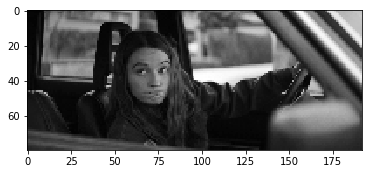

In [7]:
plt.imshow(frame_pil, cmap='gray')

In [8]:
frame_array = img_to_array(frame_pil)
type(frame_array)

numpy.ndarray

In [9]:
frame_array.shape

(80, 192, 1)

In [10]:
frame_array = frame_array.reshape((80, 192))
frame_array.shape

(80, 192)

### Load all images
Next, we'll load all images. We'll compile all of the frames' PIL.Image data in a list, and then convert that into a NumPy array ready for processing.

In [11]:
train_images_list = []
for frame in os.listdir(frame_folder):
    frame_pil = load_img(frame_folder + frame, color_mode = 'grayscale', target_size=size)
    frame_array = img_to_array(frame_pil)
    frame_array = frame_array.reshape((80, 192))
    train_images_list.append(frame_array)
    
len(train_images_list)

12541

In [12]:
train_images = np.asarray(train_images_list)

In [13]:
train_images.shape

(12541, 80, 192)

In [14]:
train_images = train_images.reshape(train_images.shape[0], 80, 192, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [15]:
BUFFER_SIZE = len(train_images_list)
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)